In [1]:
import matplotlib.pyplot as plt

colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt


In [19]:

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=1)
        self.norm = nn.BatchNorm2d(embed_dim)  # LayerNorm 대신 BatchNorm2d 사용

    def forward(self, x):
        x = self.proj(x)
        x = self.norm(x)
        x = x.flatten(2)  # (B, E, P)
        x = x.transpose(1, 2)  # (B, P, E)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.layernorm3 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x_norm1 = self.layernorm1(x)
        attn_output, _ = self.attention(x_norm1, x_norm1, x_norm1)
        x = x + attn_output
        x = self.layernorm2(x)

        x_mlp_output = self.mlp(x)
        x = x + x_mlp_output
        x = self.layernorm3(x)
        return x

class ConvHead(nn.Module):
    def __init__(self, embed_dim=768, output_channels=11, output_size=30):
        super().__init__()
        self.conv = nn.Conv2d(embed_dim, output_channels, kernel_size=3, stride=1, padding=1)
        self.output_size = output_size

    def forward(self, x):
        B, P, E = x.shape
        H = W = int(P ** 0.5)  # Assumes square grid of patches
        x = x.transpose(1, 2).reshape(B, E, H, W)  # (B, E, H, W)
        x = self.conv(x)  # (B, output_channels, H, W)
        return nn.functional.interpolate(x, size=(self.output_size, self.output_size), mode='bilinear', align_corners=False)

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, num_heads=12, num_layers=12, output_channels=11, output_size=30, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        #self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)
        self.transformer_encoders = nn.Sequential(
            *[TransformerEncoder(embed_dim, num_heads, mlp_dim, dropout) for _ in range(num_layers)]
        )
        self.norm = nn.LayerNorm(embed_dim)
        self.head = ConvHead(embed_dim, output_channels, output_size)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        #x = x + self.pos_embed
        x = self.pos_drop(x)
        x = self.transformer_encoders(x)
        x = self.norm(x)
        x = x[:, 1:]  # Remove cls_token before passing to the head
        logits = self.head(x)
        return logits




torch.Size([1, 11, 30, 30])


In [25]:
from thop import profile
from thop import clever_format

# 모델 생성 및 출력
model_args =  {
    "img_size": 30,
    "patch_size": 3,
    "in_channels": 1,
    "embed_dim": 256,
    "num_heads": 8,
    "num_layers": 8,
    "mlp_dim": 2048,
    "dropout": 0.1,
    "output_channels": 11,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(**model_args).to(device)

# 입력 텐서 생성
x = torch.randn(1, 1, 30, 30).to(device)

# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(model, inputs=(x,))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    print(f"Input shape: {x.shape}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPs: 6.628G
파라미터 수: 8.448M


In [24]:
from bw_net_maml import BWNet_MAML

model = BWNet_MAML(embed_size=1).to(device)

# 입력 텐서 생성
x = torch.randn(1, 1, 30, 30).to(device)

# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(model, inputs=(x,))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    print(f"Input shape: {x.shape}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPs: 170.407M
파라미터 수: 141.277M


Using cuda device
Epoch 1/50


Validation:  98%|█████████▊| 41/42 [00:48<00:01,  1.26s/it]

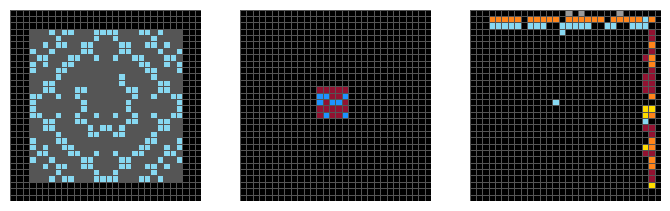

Validation: 100%|██████████| 42/42 [00:49<00:00,  1.18s/it]


Epoch 1/50, Loss: 1130.820556640625, Accuracy: 0.3052653867871259%
Epoch 2/50


Training:   0%|          | 0/42 [00:00<?, ?it/s]

In [4]:

import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import gc


colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def criterion(y_pred, y):
    y = y.long().squeeze(1)
    ce = F.cross_entropy(y_pred, y, ignore_index=0)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 500,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    'embed_size': 1,
}
model_args =  {
    "img_size": 30,
    "patch_size": 3,
    "in_channels": 1,
    "embed_dim": 256,
    "num_heads": 8,
    "num_layers": 8,
    "mlp_dim": 2048,
    "dropout": 0.1,
    "output_channels": 11,
}
# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device  
print(f'Using {device} device')

train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

# Outer Model 정의
outer_model = VisionTransformer(**model_args).to(device)
outer_optimizer = optim.AdamW(outer_model.parameters(), lr=kwargs['outer_lr'])

# Training Loop
for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    outer_model.train()
    
    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            # Inner loop
            inner_model = deepcopy(outer_model)
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])

            for _ in range(kwargs['example_data_num']):  # 여러 번의 Inner Update 수행
                inner_model.train()
                prediction = inner_model(example_input[task_number])
                loss = criterion(prediction, example_output[task_number])

                inner_optimizer.zero_grad()
                loss.backward()
                inner_optimizer.step()
            
            # Inner loop가 끝난 후, outer_model의 손실 계산을 위해 inner_model의 파라미터를 사용
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        # Outer loop에서 모든 task의 손실을 누적하여 업데이트
        meta_loss = torch.stack(task_losses).mean()  # 모든 task의 손실 평균
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()

        # 메모리 해제
        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()

    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
            input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

            for task_number in range(input_tensor.shape[0]):
                ex_input = example_input[task_number]
                ex_output = example_output[task_number]
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]

                eval_prediction = outer_model(ex_input)
                loss = criterion(eval_prediction, ex_output)
                
                task_prediction = outer_model(task_input)
                task_loss = criterion(task_prediction, task_output)
                total_loss += task_loss

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                # 정답이 0이 아닌 부분만 선택하여 정확도 계산
                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()  # 0이 아닌 부분만 계산

                # 시각화: 마지막 배치의 마지막 task에서만 실행
                if batch_idx == len(eval_loader) - 1 and task_number == input_tensor.shape[0] - 1:
                    show_grid_side_by_side(task_input.cpu(), task_output.cpu(), prediction_class.cpu())

                # 메모리 해제
                del ex_input, ex_output, task_input, task_output, eval_prediction, task_prediction, mask, correct_predictions
                gc.collect()
                torch.cuda.empty_cache()

    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0  # 정확도 계산
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {total_loss.item()}, Accuracy: {accuracy}%')

    torch.cuda.empty_cache()